<a href="https://colab.research.google.com/github/pleask/sLIME/blob/main/tutorials/generated_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# sLIME for Generated Datasets
This tutorial is a walkthrough on how to apply sLIME to explainability problems where we have access to the underlying generative process for the images. This is an unlikely scenario, but clearly demonstrates use of sLIME for arbitrary features without the additional complexity of building transformers.

We use the [sLIME Shapes](https://github.com/pleask/slime-shapes) dataset, which consists of coloured geometric shapes on a coloured background.

In [1]:
%%capture
!pip install git+https://github.com/pleask/slime-shapes.git
!pip install git+https://github.com/pleask/sLIME.git

import matplotlib.pyplot as plt
%matplotlib inline

from dataclasses import dataclass
import numpy as np

@dataclass
class TitledImage:
  title: str
  img: np.ndarray

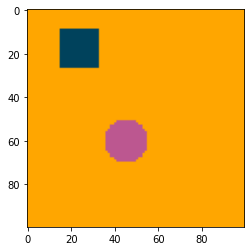

In [2]:
from slime_shapes import shapes

positions = shapes.get_positions(100, 2)
canvas = shapes.Square(positions[0], colour=shapes.ORANGE).create_canvas()
shapes.Square(positions[1], colour=shapes.BLUE).add_to_image(canvas)
shapes.Circle(positions[2], colour=shapes.PINK).add_to_image(canvas)
plt.imshow(canvas);

## Classification Problem
We formulate the following classification problem. We have a dataset of images that belong to four different classes; each image consists of a coloured background, and may contain a square, a circle, or both. The sizes of the shapes are random, within a range, and are also randomly placed, except that they may not overlap or extend beyond the boundaries of the image. The background is known to take any colour, but the shapes are always blue. Pretend that the different shapes represent different animals, and the background is just wherever they happen to be standing when the photo is taken.


In [3]:
"""
Classes for generating the data during training and validation.
"""
from typing import Union, Callable
from tensorflow.keras.utils import Sequence
from tensorflow import stack

CANVAS_SIZE = 32

@dataclass
class ShapesClass:
  class_id: int
  name: str
  shapes: list
  # allow callbacks for getting random colours later
  background_colour: Union[shapes.Shape, Callable]

class ShapeClassificationDataset(Sequence):
  """
  Dataset of shapes images and their classes. A list of ShapesClass objects is
  used to specify which classes to generate (particularly their background).
  """
  def __init__(self, classes, size, batch_size, canvas_size=CANVAS_SIZE):
    self._classes = classes
    self._batch_size = batch_size
    self._size = size
    self._canvas_size = canvas_size

  def __len__(self):
    return self._size // self._batch_size

  def __getitem__(self, idx):
    """
    Gets the idx-th batch of examples. Reproducibility is ignored here for
    brevity, each batch consists of random examples.
    """
    xs, ys = [], []
    for _ in range(self._batch_size // len(self._classes)):
      for c in self._classes:
        x, y, = self._generate_instance(c)
        xs.append(x)
        ys.append(y)
    return stack(xs), stack(ys)
  
  def _generate_instance(self, c):
    positions = shapes.get_positions(self._canvas_size, len(c.shapes), min_ratio=0.25, max_ratio=0.375)
    try:
      background_colour = c.background_colour()
    except TypeError:
      background_colour = c.background_colour
    canvas = shapes.Square(positions[0], colour=background_colour).create_canvas()
    for i, shape in enumerate(c.shapes):
      shape(positions[i+1], colour=shapes.BLUE).add_to_image(canvas)
    return canvas / 255.0, c.class_id

Due to bias in collecting the training data, each class was seen only on a single background (eg. all images containing only a circle were seen on an orange background, and all images containing only a square were seen on a pink background). For animals, this may be like only having photos of a tiger on a snowy background, despite their range extending into jungle and grassland.

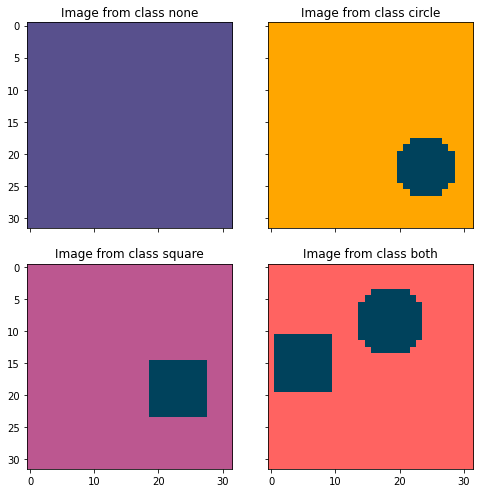

In [4]:
"""
The fixed background dataset the model will initially be trained with.
"""
from mpl_toolkits.axes_grid1 import ImageGrid

fixed_background_classes = [
  ShapesClass(0, 'none', [], shapes.PURPLE),
  ShapesClass(1, 'circle', [shapes.Circle], shapes.ORANGE),
  ShapesClass(2, 'square', [shapes.Square], shapes.PINK),
  ShapesClass(3, 'both', [shapes.Circle, shapes.Square], shapes.SALMON),
]

batch = ShapeClassificationDataset(fixed_background_classes, 4, 4)[0]
images = []
for i in range(4):
  images.append(TitledImage(
    f'Image from class {fixed_background_classes[i].name}',
    batch[0][i]
  ))
fig = plt.figure(figsize=(8., 12.))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.5)
for ax, im in zip(grid, images):
  ax.imshow(im.img)
  ax.set_title(im.title)

This sampling bias means that there are two clear ways of identifying these classes: either by using the shapes, or by using the colour of the background. However, this is an issue, as we already know the background cannot be solely used for classification. When we build our classification model, we want to check whether it uses the shapes or the background.

In [6]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def get_shape_classifier(background_classes):
  num_classes = len(background_classes)

  model = Sequential([
    layers.Conv2D(4, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
  ])

  model.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  epochs=3
  history = model.fit(
    ShapeClassificationDataset(background_classes, 10000, 32),
    validation_data=ShapeClassificationDataset(background_classes, 1000, 32),
    epochs=epochs
  )

  return model

shape_classifier = get_shape_classifier(fixed_background_classes)

Epoch 1/3
312/312 [==============================] - 17s 46ms/step - loss: 0.1757 - accuracy: 0.9234 - val_loss: 1.7260e-04 - val_accuracy: 1.0000
Epoch 2/3
312/312 [==============================] - 18s 59ms/step - loss: 8.7869e-05 - accuracy: 1.0000 - val_loss: 3.9984e-05 - val_accuracy: 1.0000
Epoch 3/3
312/312 [==============================] - 14s 45ms/step - loss: 2.7189e-05 - accuracy: 1.0000 - val_loss: 1.6294e-05 - val_accuracy: 1.0000


This network performs (predictably) well on the sampled images with fixed backgrounds per class.

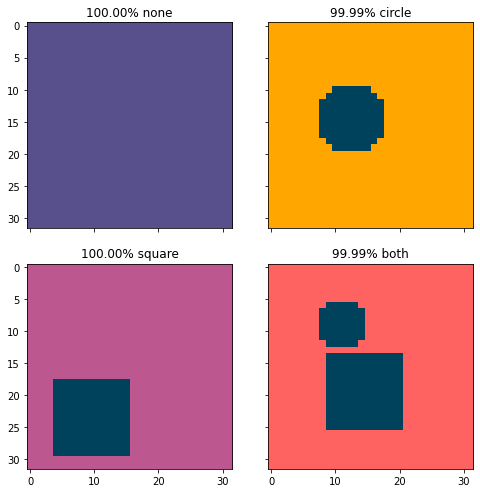

In [53]:
from tensorflow.keras.utils import img_to_array
from tensorflow.nn import softmax

def show_class_predictions(classes, model):
  batch = ShapeClassificationDataset(classes, 4, 4)[0][0]
  predictions = model.predict(batch)
  scores = softmax(predictions)

  images = []
  for i in range(4):
    class_name = classes[np.argmax(scores[i])].name
    confidence = np.max(scores[i])
    title = f'{100*confidence:.2f}% {class_name}'
    images.append(TitledImage(title, batch[i]))
  fig = plt.figure(figsize=(8., 12.))
  grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.5)
  for ax, im in zip(grid, images):
    ax.imshow(im.img)
    ax.set_title(im.title)

show_class_predictions(fixed_background_classes, shape_classifier)

## Out of Distribution
Earlier we hypothesised that the model would use the background colour to classify the images, learning a simple function of the pixels in the image (eg. what colour are the pixels that aren't blue?) is simpler than learning to detect the randomly placed shapes.

We can quickly sense check this by classifying an image of a square on an orange background. If the model is relying on the background rather than the shape, this image will be classified as a circle.

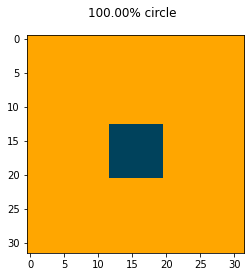

In [8]:
from tensorflow import stack

positions = shapes.get_positions(CANVAS_SIZE, 2, min_ratio=0.25, max_ratio=0.375)
out_of_distribution_img = shapes.Square(positions[0], colour=shapes.ORANGE).create_canvas()
shapes.Square(positions[1], colour=shapes.BLUE).add_to_image(out_of_distribution_img)

predictions = shape_classifier.predict(stack([out_of_distribution_img / 255.0]))
score = softmax(predictions)[0]
class_name = fixed_background_classes[np.argmax(score)].name
confidence = np.max(score)

fig = plt.figure(figsize=(4., 4.))
fig.suptitle(f'{100*confidence:.2f}% {class_name}')
plt.imshow(out_of_distribution_img);

As expected, the model erroneously classifies this instance as a circle. We guessed here that changing the background would change the classification, but we can also do this systematically using LIME. 

To do this, we can use a `BinaryPerturber` subclass, where we generate perturbed instances with each of the features turned on or off. The features under consideration here are the background colour, and the presence (or lack) of shapes.

While we can independendently place circles and squares, the background colours are not independent of one another (ie. the background cannot be both pink and blue at the same time). As we are interested in the background colour as a general concept, rather than the specific colour used, we will use an ordering on the colours such that if multiple colours are active, we only use one of them. This will result in some confounding effects, and the local model will not be accurate for changes in the background colour.

  0%|          | 0/1000 [00:00<?, ?it/s]

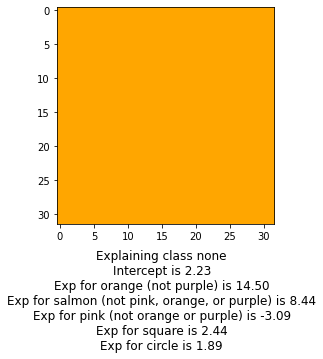

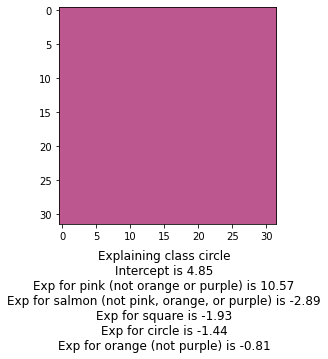

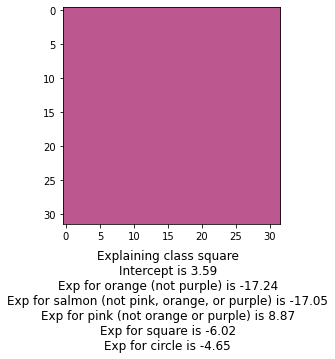

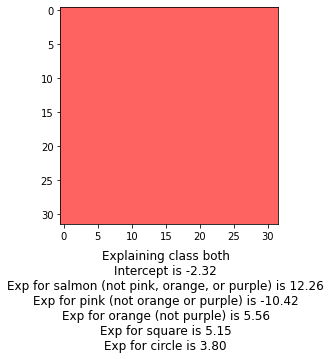

In [49]:
from slime.transform import BinaryPerturber
from sklearn.metrics import pairwise_distances
from slime.explain import Explainer

class GenerativeShapePerturber(BinaryPerturber):
  """
  Perturb a given shapes image based on an array of activated features.
  """
  def __init__(self, positions, canvas_size=100):
    self._canvas_position = positions[0]
    self._square_position = positions[1]
    self._circle_position = positions[2]
    self._canvas_size = canvas_size

  def perturb(self, enabled_features):
    background_colour = shapes.PURPLE
    if enabled_features[0]:
      background_colour = shapes.ORANGE
    elif enabled_features[1]:
      background_colour = shapes.PINK
    elif enabled_features[2]:
      background_colour = shapes.SALMON

    canvas = shapes.Square(self._canvas_position, colour=background_colour).create_canvas()
    if enabled_features[3]:
      shapes.Circle(self._circle_position, colour=shapes.BLUE).add_to_image(canvas)
    if enabled_features[4]:
      shapes.Square(self._square_position, colour=shapes.BLUE).add_to_image(canvas)

    return canvas / 255.0

  @property
  def feature_count(self):
    return 5

def feature_to_readable(i):
  return {
      0: 'orange (not purple)', 
      1: 'pink (not orange or purple)', 
      2: 'salmon (not pink, orange, or purple)', 
      3: 'circle', 
      4: 'square', 
  }[i]

perturber = GenerativeShapePerturber(positions)

def metric(baseline, prediction):
  return pairwise_distances(
      [prediction],
      baseline.reshape(1, -1),
      metric='cosine'
  ).ravel()

explainer = Explainer(metric, kernel_width=2, random_state=5)
explanation = explainer.explain_instance(perturber, shape_classifier.predict, top_labels=20, num_features=100, num_samples=1000)

def print_explanation(feature_to_readable, explanation):
  classes_to_explain = list(explanation.local_exp.keys())
  explanations = [explanation.explain(c, num_features=1) for c in classes_to_explain]
  
  for i, c in enumerate(classes_to_explain):
    figtext_lines = [
      f'Explaining class {fixed_background_classes[i].name}',
      f'Intercept is {explanation.intercept[c]:.2f}'
    ]
    for exp in explanation.local_exp[c]:
      figtext_lines.append(f'Exp for {feature_to_readable(exp[0])} is {exp[1]:.2f}')
    plt.figure(figsize=(4., 4.))
    plt.imshow(explanations[i])
    plt.figtext(0.5, -0.30, 
      '\n'.join(figtext_lines), 
      wrap=True, horizontalalignment='center', fontsize=12
    )

print_explanation(feature_to_readable, explanation)

The confounding between the background colours make those local model coefficients somewhat difficult to interpret (eg. one colour may be positive because it counteracts a strongly negative colour). In general, though, the impact of the background vs the shapes is clear from the size of the coefficients. In all explanations, the background colour dominates the presence of the shapes.

We can also verify this by using the superpixel approach from the original LIME paper. By segmenting the image and removing those areas, we can see which part of the image the classifier is relying on most in its predictions.

  0%|          | 0/1000 [00:00<?, ?it/s]

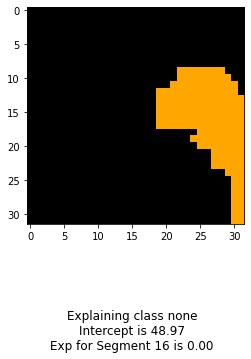

In [50]:
from tensorflow import convert_to_tensor, double, float64
from slime.transform import TransformerPerturber, SegmentTransformer
from lime.wrappers.scikit_image import SegmentationAlgorithm

def get_segment_transformers(img, dtype=float64, kernel_size=4, max_dist=200):
  segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=kernel_size, max_dist=max_dist, ratio=0.2, random_seed=5)
  segments = segmentation_fn(img)
  segment_values = np.unique(segments)
  transformers = []
  for v in segment_values:
    mask = 1 - (segments == v)
    mask = mask[..., np.newaxis]
    mask = convert_to_tensor(mask, dtype=dtype)
    transformers.append(SegmentTransformer(mask))
  img = convert_to_tensor(img, dtype=dtype)
  tp = TransformerPerturber(img, transformers)
  return tp

img = convert_to_tensor(perturber.perturb([True, False, False, True, False]), dtype=double)
tp = get_segment_transformers(img, dtype=double, kernel_size=2, max_dist=1)

explainer = Explainer(metric, random_state=5) 
explanation = explainer.explain_instance(tp, shape_classifier.predict, top_labels=1, num_features=1, num_samples=1000)
print_explanation(lambda x: f'Segment {x}', explanation)

## Fixing the Model
Now that we've established that the model erroneously uses the background colour of the image for classification, we can attempt to fix this by retraining the model uses a mix of background colours for each class. This means that the background colour cannot be used to determine the class.

Using a generated dataset, it is very easy to acquire these data, which may not be the case with real-world datasets. See the sLIME paper for suggestions on how to circumvent this issue.

Epoch 1/3
312/312 [==============================] - 15s 46ms/step - loss: 0.6687 - accuracy: 0.6647 - val_loss: 0.4227 - val_accuracy: 0.7611
Epoch 2/3
312/312 [==============================] - 14s 46ms/step - loss: 0.3774 - accuracy: 0.7958 - val_loss: 0.3371 - val_accuracy: 0.8125
Epoch 3/3
312/312 [==============================] - 14s 46ms/step - loss: 0.3200 - accuracy: 0.8429 - val_loss: 0.2317 - val_accuracy: 0.8942


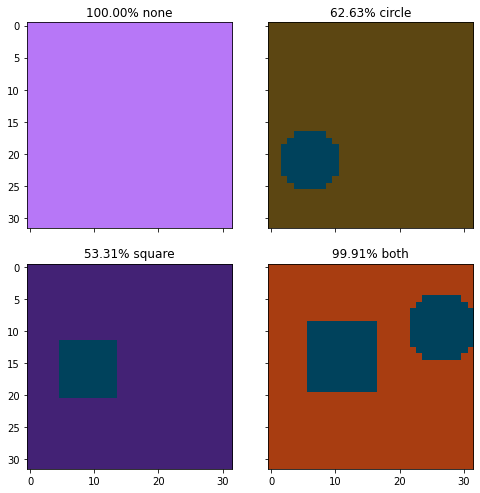

In [54]:
get_random_colour = lambda: np.random.randint(0, 255, size=(3))

random_background_classes = [
  ShapesClass(0, 'none', [], get_random_colour),
  ShapesClass(1, 'circle', [shapes.Circle], get_random_colour),
  ShapesClass(2, 'square', [shapes.Square], get_random_colour),
  ShapesClass(3, 'both', [shapes.Circle, shapes.Square], get_random_colour),
]

fixed_shape_classifier = get_shape_classifier(random_background_classes)
show_class_predictions(random_background_classes, fixed_shape_classifier)

These example suggest that the new model is performing correctly (if with considerably lower confidence than our previous model), but, as before, we can use sLIME to assess whether the shapes or background colour have more impact on the classification.

  0%|          | 0/1000 [00:00<?, ?it/s]

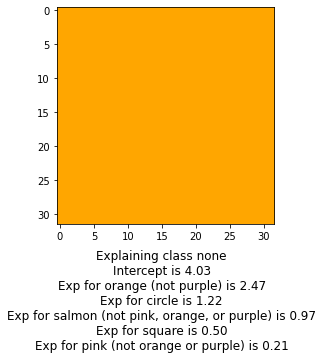

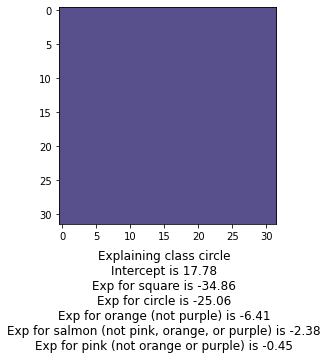

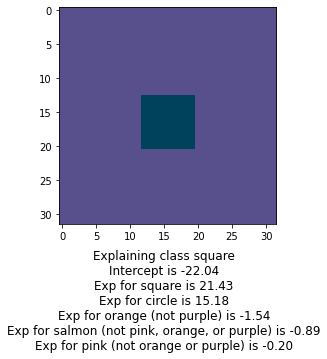

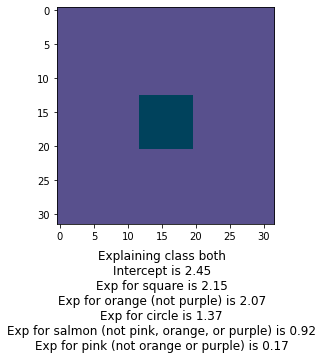

In [56]:
explainer = Explainer(metric, kernel_width=2.0, random_state=5)
explanation = explainer.explain_instance(perturber, fixed_shape_classifier.predict, top_labels=20, num_features=100, num_samples=1000)
print_explanation(feature_to_readable, explanation)

Again, to double check our findings, we can use the superpixel method. However, here it is worth highlighting one of the key drawbacks to the superpixel approach: we don't know why the superpixel is relevant to the explanation. For example, it may be the colour of the superpixel, or it may be the shape of its adjacent edge to a shape.

  0%|          | 0/1000 [00:00<?, ?it/s]

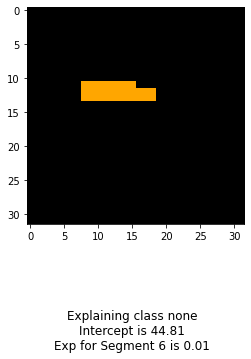

In [60]:
img = convert_to_tensor(perturber.perturb([True, False, False, True, False]), dtype=double)
tp = get_segment_transformers(img, dtype=double, kernel_size=2, max_dist=1)

explainer = Explainer(metric, random_state=5) 
explanation = explainer.explain_instance(tp, fixed_shape_classifier.predict, top_labels=1, num_features=1, num_samples=1000)
print_explanation(lambda x: f'Segment {x}', explanation)